# Práctica Multiobjetivo – ZDT3

Este notebook contiene **solo** la parte multiobjetivo (ZDT3) y la comparación entre:
- **Nuestro GA** (GA adaptado a multiobjetivo con Pareto ranks + crowding)
- **NSGA-II** (pymoo)
- **SPEA2** (pymoo)

Budget: **10.000 evaluaciones** (POP=100, GEN=100).

In [75]:
import numpy as np
import random, copy
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import Hypervolume


problem = get_problem('zdt3')  # 30 variables en [0,1]
N_VAR = problem.n_var
XL, XU = problem.xl, problem.xu

BUDGET = 10_000
POP_SIZE = 100
N_GEN = BUDGET // POP_SIZE  # 100 gen -> 10k evals


## Funciones auxiliares: evaluación, Pareto (ranks) y crowding distance

In [76]:
def eval_pop(X):
    # X: (N, n_var)
    return problem.evaluate(X, return_values_of=['F'])

def nd_ranks(F):
    # ranks tipo NSGA: 0 = no dominado, 1 = siguiente, etc.
    nds = NonDominatedSorting()
    fronts = nds.do(F)
    rank = np.empty(len(F), dtype=int)
    for r, front in enumerate(fronts):
        rank[front] = r
    return fronts, rank

def crowding_distance(F_front):
    # F_front: (k, m)
    k = len(F_front)
    if k == 0:
        return np.array([])
    if k <= 2:
        return np.full(k, np.inf)

    m = F_front.shape[1]
    cd = np.zeros(k, dtype=float)

    for j in range(m):
        order = np.argsort(F_front[:, j])
        cd[order[0]] = np.inf
        cd[order[-1]] = np.inf

        fmin = F_front[order[0], j]
        fmax = F_front[order[-1], j]
        if fmax == fmin:
            continue

        for t in range(1, k - 1):
            if np.isinf(cd[order[t]]):
                continue
            prevv = F_front[order[t - 1], j]
            nextv = F_front[order[t + 1], j]
            cd[order[t]] += (nextv - prevv) / (fmax - fmin)

    return cd


In [77]:
def calculate_metrics(front, ref_point):
    """HV (↑ mejor), Dispersión SPR (↑ más disperso), Espaciado SPA (↓ más uniforme)."""
    metricHV = Hypervolume(ref_point)
    hv = metricHV.do(front)

    # Dispersión (SPR): diagonal de la hipercaja del frente
    min_values = np.min(front, axis=0)
    max_values = np.max(front, axis=0)
    spr = np.linalg.norm(max_values - min_values)

    # Espaciado (SPA): promedio de distancia al vecino más cercano (↓ mejor)
    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)
    np.fill_diagonal(d, np.inf)
    spa = np.mean(np.min(d, axis=1))

    return hv, spr, spa

## NSGA-II y SPEA2 (pymoo) con el mismo budget

In [78]:
def run_nsga2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN):
    algo = NSGA2(
        pop_size=pop_size,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(prob=1.0/N_VAR, eta=20),
        eliminate_duplicates=True
    )
    res = minimize(problem, algo, ('n_gen', n_gen), seed=seed, verbose=False)
    F = res.pop.get('F')
    nd = NonDominatedSorting().do(F, only_non_dominated_front=True)
    return {"F": F, "F_nd": F[nd]}

def run_spea2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN):
    algo = SPEA2(
        pop_size=pop_size,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(prob=1.0/N_VAR, eta=20),
        eliminate_duplicates=True
    )
    res = minimize(problem, algo, ('n_gen', n_gen), seed=seed, verbose=False)
    F = res.pop.get('F')
    nd = NonDominatedSorting().do(F, only_non_dominated_front=True)
    return {"F": F, "F_nd": F[nd]}


## Adaptación de GA a multiobjetivo (selección por rank + crowding)
La idea: generar hijos igual que siempre, pero **para formar la siguiente población** usamos:
1) primero los frentes no dominados (rank 0, luego rank 1...)
2) dentro del mismo frente, preferimos mayor **crowding** (más diversidad).

In [79]:
def create_population_mo(pop_size=POP_SIZE):
    return np.random.uniform(XL, XU, size=(pop_size, N_VAR))

def arithmetic_crossover_vec(p1, p2, pcross=0.9):
    if random.random() > pcross:
        return p1.copy(), p2.copy()
    alpha = random.random()
    c1 = alpha * p1 + (1 - alpha) * p2
    c2 = (1 - alpha) * p1 + alpha * p2
    return c1, c2

def gaussian_mutation_vec(x, pmut=None, sigma=0.1):
    if pmut is None:
        pmut = 1.0 / N_VAR
    y = x.copy()
    for i in range(len(y)):
        if random.random() < pmut:
            y[i] += random.gauss(0, sigma)
    return np.clip(y, XL, XU)

def environmental_selection(pop, F, pop_size=POP_SIZE):
    fronts, rank = nd_ranks(F)

    new_idx = []
    crowd = np.zeros(len(pop), dtype=float)

    for front in fronts:
        if len(new_idx) + len(front) <= pop_size:
            cd = crowding_distance(F[front])
            crowd[front] = cd
            new_idx.extend(front.tolist())
        else:
            # llenar con crowding
            cd = crowding_distance(F[front])
            crowd[front] = cd
            remaining = pop_size - len(new_idx)
            # elegimos mayor crowding
            order = np.argsort(-cd)  # desc
            chosen = front[order[:remaining]]
            new_idx.extend(chosen.tolist())
            break

    new_idx = np.array(new_idx, dtype=int)
    return pop[new_idx], F[new_idx], rank[new_idx], crowd[new_idx]

def tournament_select(pop, rank, crowd):
    # torneo binario: menor rank gana; si empate, mayor crowding
    i, j = random.randrange(len(pop)), random.randrange(len(pop))
    if rank[i] < rank[j]:
        return pop[i]
    if rank[j] < rank[i]:
        return pop[j]
    # empate
    return pop[i] if crowd[i] > crowd[j] else pop[j]

def evolve_my_mo(seed=0, pop_size=POP_SIZE, n_gen=N_GEN, pcross=0.9, pmut=None, sigma=0.1):
    random.seed(seed)
    np.random.seed(seed)

    pop = create_population_mo(pop_size)
    F = eval_pop(pop)
    evals = pop_size

    # preparar rank/crowd inicial
    pop, F, rank, crowd = environmental_selection(pop, F, pop_size)

    for _ in range(n_gen):
        # reproducción
        children = []
        while len(children) < pop_size:
            p1 = tournament_select(pop, rank, crowd)
            p2 = tournament_select(pop, rank, crowd)
            c1, c2 = arithmetic_crossover_vec(p1, p2, pcross)
            c1 = gaussian_mutation_vec(c1, pmut=pmut, sigma=sigma)
            c2 = gaussian_mutation_vec(c2, pmut=pmut, sigma=sigma)
            children.append(c1)
            if len(children) < pop_size:
                children.append(c2)

        children = np.array(children)
        Fc = eval_pop(children)
        evals += pop_size

        # unión y selección ambiental
        pop = np.vstack([pop, children])
        F = np.vstack([F, Fc])
        pop, F, rank, crowd = environmental_selection(pop, F, pop_size)

    nd = NonDominatedSorting().do(F, only_non_dominated_front=True)
    return {
        "pop": pop,
        "F": F,
        "F_nd": F[nd],
        "evals": evals
    }


## Experimento único (una semilla) + gráfica de frentes

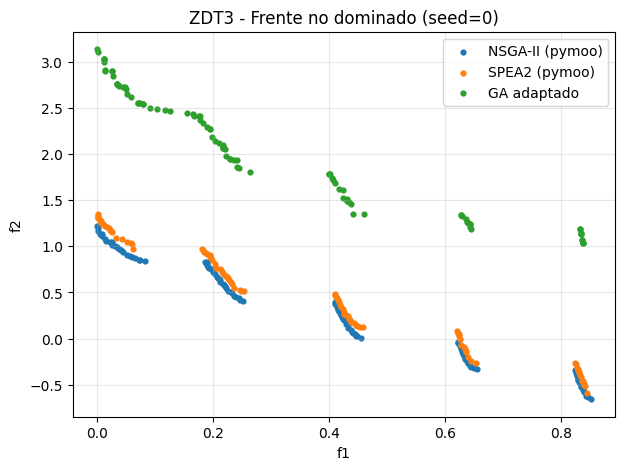

In [ ]:
seed = 0

my = evolve_my_mo(seed=seed)
ns = run_nsga2(seed=seed)
sp = run_spea2(seed=seed)

plt.figure(figsize=(7,5))
plt.scatter(ns["F_nd"][:,0], ns["F_nd"][:,1], s=12, label="NSGA-II (pymoo)")
plt.scatter(sp["F_nd"][:,0], sp["F_nd"][:,1], s=12, label="SPEA2 (pymoo)")
plt.scatter(my["F_nd"][:,0], my["F_nd"][:,1], s=12, label="GA adaptado")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("ZDT3 - Frente no dominado (seed=0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Varios experimentos (≥10) + métricas (HV e IGD) + tabla
HV (Hypervolume): más alto = mejor.
IGD: más bajo = mejor.
Para IGD usamos una referencia de frente `pareto_front()` de ZDT3 (pymoo).

In [81]:
import pandas as pd

ref_point = np.array([1.2, 1.2])
rows = []

for seed in range(10):
    ag = evolve_my_mo(seed=seed)
    ns = run_nsga2(seed)
    sp = run_spea2(seed)

    hv_ag, spr_ag, spa_ag = calculate_metrics(ag["F_nd"], ref_point)
    hv_n,  spr_n,  spa_n  = calculate_metrics(ns["F_nd"], ref_point)
    hv_s,  spr_s,  spa_s  = calculate_metrics(sp["F_nd"], ref_point)

    rows.append({
        "seed": seed,
        "HV_AG": hv_ag, "SPR_AG": spr_ag, "SPA_AG": spa_ag,
        "HV_NSGA2": hv_n, "SPR_NSGA2": spr_n, "SPA_NSGA2": spa_n,
        "HV_SPEA2": hv_s, "SPR_SPEA2": spr_s, "SPA_SPEA2": spa_s
    })

df = pd.DataFrame(rows)
df


,seed,HV_AG,SPR_AG,SPA_AG,HV_NSGA2,SPR_NSGA2,SPA_NSGA2,HV_SPEA2,SPR_SPEA2,SPA_SPEA2
0,0,0.062707,2.261655,0.011622,1.466656,2.057442,0.013968,1.355625,2.115626,0.014077
1,1,0.000000,1.858921,0.014830,1.300137,2.119788,0.014620,1.387049,2.087460,0.015027
2,2,0.024190,1.625258,0.019070,1.361181,2.105969,0.014754,1.487489,2.008224,0.014863
3,3,0.000000,1.805729,0.018512,1.520634,2.031596,0.014105,1.435864,2.079666,0.015616
4,4,0.000000,2.045481,0.016782,1.469408,2.052401,0.015408,1.387812,2.069222,0.015139
5,5,0.000000,1.592488,0.011619,1.445224,2.065700,0.014888,1.434017,2.084197,0.014903
6,6,0.000000,2.161880,0.017234,1.310247,2.110584,0.015628,1.414427,2.093946,0.013738
7,7,0.050191,2.279126,0.017372,1.341846,2.117134,0.016005,1.472660,2.025020,0.014874
8,8,0.000000,1.433238,0.014604,1.336811,2.087438,0.013596,1.427545,2.092699,0.013133
9,9,0.000000,1.812864,0.012490,1.457788,2.055565,0.014684,1.394339,2.090941,0.015584


### Estadísticas (media y desviación típica)

In [82]:
summary_hv_spa = df[[
    "HV_AG", "SPA_AG",
    "HV_NSGA2", "SPA_NSGA2",
    "HV_SPEA2", "SPA_SPEA2"
]].agg(["mean", "std"])

summary_hv_spa

,HV_AG,SPA_AG,HV_NSGA2,SPA_NSGA2,HV_SPEA2,SPA_SPEA2
mean,0.013709,0.015413,1.400993,0.014766,1.419683,0.014696
std,0.023938,0.002795,0.078950,0.000758,0.040534,0.000802


## Mejor experimento de AG

Best seed (AG) = 0


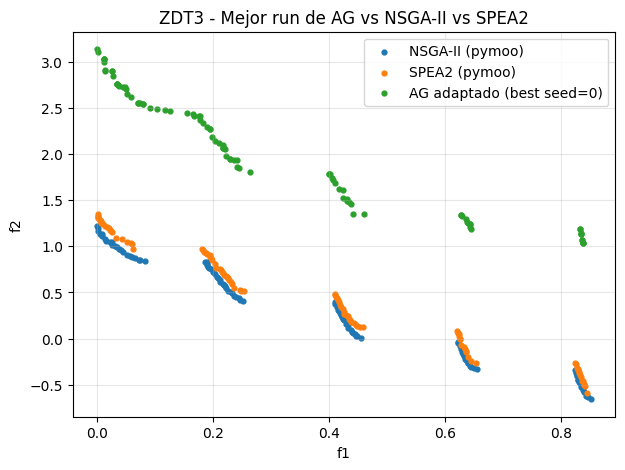

In [83]:
best_seed = int(df.loc[df["HV_AG"].idxmax(), "seed"])
print("Best seed (AG) =", best_seed)

my = evolve_my_mo(seed=best_seed)
ns = run_nsga2(seed=best_seed)
sp = run_spea2(seed=best_seed)

plt.figure(figsize=(7,5))
plt.scatter(ns["F_nd"][:,0], ns["F_nd"][:,1], s=12, label="NSGA-II (pymoo)")
plt.scatter(sp["F_nd"][:,0], sp["F_nd"][:,1], s=12, label="SPEA2 (pymoo)")
plt.scatter(my["F_nd"][:,0], my["F_nd"][:,1], s=12, label=f"AG adaptado (best seed={best_seed})")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("ZDT3 - Mejor run de AG vs NSGA-II vs SPEA2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Operadores alternativos: SBX + Mutación Polinómica (Deb)

Para mejorar el rendimiento del AG en ZDT3, se sustituyen los operadores del AG original (cruce aritmético y mutación gaussiana) por dos operadores estándar en optimización multiobjetivo con variables reales:

- **SBX (Simulated Binary Crossover)**: genera descendencia combinando dos padres de forma similar a un cruce binario, pero en variables reales. Mantiene mejor diversidad que el cruce aritmético y facilita explorar el frente (especialmente en problemas tipo ZDT).
- **Mutación Polinómica (Polynomial Mutation, Deb)**: introduce perturbaciones controladas sobre cada variable con probabilidad `pmut`. Está diseñada para espacios continuos acotados y suele funcionar mejor que una gaussiana fija en este tipo de benchmarks.

Ambos operadores respetan los límites de búsqueda `[XL, XU]` (por variable).

In [84]:
def sbx_crossover_vec(p1, p2, pcross=0.9, eta=15):
    """
    SBX (Simulated Binary Crossover) para variables reales en [XL,XU].
    Devuelve dos hijos.
    """
    if random.random() > pcross:
        return p1.copy(), p2.copy()

    n = len(p1)
    c1 = p1.copy()
    c2 = p2.copy()

    for i in range(n):
        u = random.random()
        if u <= 0.5:
            beta = (2*u) ** (1/(eta+1))
        else:
            beta = (1/(2*(1-u))) ** (1/(eta+1))

        # combinación SBX
        c1[i] = 0.5*((1+beta)*p1[i] + (1-beta)*p2[i])
        c2[i] = 0.5*((1-beta)*p1[i] + (1+beta)*p2[i])

    return np.clip(c1, XL, XU), np.clip(c2, XL, XU)

def polynomial_mutation_vec(x, pmut=None, eta=20):
    """
    Polynomial Mutation (Deb) para variables reales con bounds por variable.
    XL y XU pueden ser escalares o arrays de tamaño N_VAR.
    """
    if pmut is None:
        pmut = 1.0 / N_VAR

    y = x.copy()

    for i in range(len(y)):
        if random.random() < pmut:

            # bounds por variable (sirve si XL/XU son escalares o arrays)
            xl_i = XL[i] if np.ndim(XL) > 0 else XL
            xu_i = XU[i] if np.ndim(XU) > 0 else XU

            # si el rango es 0 no mutamos esa dimensión
            if xu_i <= xl_i:
                continue

            u = random.random()

            delta1 = (y[i] - xl_i) / (xu_i - xl_i)
            delta2 = (xu_i - y[i]) / (xu_i - xl_i)

            if u < 0.5:
                xy = 1.0 - delta1
                val = 2.0*u + (1.0 - 2.0*u) * (xy ** (eta + 1))
                deltaq = (val ** (1.0 / (eta + 1))) - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0*(1.0 - u) + 2.0*(u - 0.5) * (xy ** (eta + 1))
                deltaq = 1.0 - (val ** (1.0 / (eta + 1)))

            y[i] = y[i] + deltaq * (xu_i - xl_i)

    # clip por variable también
    if np.ndim(XL) > 0:
        return np.minimum(np.maximum(y, XL), XU)
    else:
        return np.clip(y, XL, XU)



## Variante del AG: AG2 (SBX + PM) con selección multiobjetivo

Se implementa una variante del algoritmo genético multiobjetivo (AG2) que mantiene la misma estructura general del AG adaptado:

1. **Inicialización** aleatoria en el dominio del problema.
2. **Evaluación** multiobjetivo (dos funciones: f1 y f2).
3. **Selección ambiental** basada en frentes no dominados (Pareto) y *crowding distance* para preservar diversidad.
4. **Reproducción** usando:
   - torneo binario considerando (rank, crowding),
   - cruce **SBX**,
   - mutación **polinómica**.
5. **Elitismo**: se une población actual + descendencia y se vuelve a seleccionar la siguiente generación mediante selección ambiental.

Además, se añade una **reinyección** opcional de un pequeño porcentaje de individuos aleatorios (`reinject_rate`) para evitar pérdida de diversidad (útil en ZDT3, cuyo frente es discontinuo).

In [85]:
def evolve_my_mo_sbxpm(seed=0, pop_size=POP_SIZE, n_gen=N_GEN, pcross=0.9, pmut=None,
                      eta_c=15, eta_m=20, reinject_rate=0.05):
    random.seed(seed)
    np.random.seed(seed)

    pop = create_population_mo(pop_size)
    F = eval_pop(pop)
    evals = pop_size

    pop, F, rank, crowd = environmental_selection(pop, F, pop_size)

    for _ in range(n_gen):
        children = []
        while len(children) < pop_size:
            p1 = tournament_select(pop, rank, crowd)
            p2 = tournament_select(pop, rank, crowd)

            c1, c2 = sbx_crossover_vec(p1, p2, pcross=pcross, eta=eta_c)
            c1 = polynomial_mutation_vec(c1, pmut=pmut, eta=eta_m)
            c2 = polynomial_mutation_vec(c2, pmut=pmut, eta=eta_m)

            children.append(c1)
            if len(children) < pop_size:
                children.append(c2)

        children = np.array(children)

        # reinyección para diversidad (opcional pero ayuda mucho en ZDT3)
        n_re = int(reinject_rate * pop_size)
        if n_re > 0:
            children[:n_re] = create_population_mo(n_re)

        Fc = eval_pop(children)
        evals += pop_size

        pop = np.vstack([pop, children])
        F = np.vstack([F, Fc])

        pop, F, rank, crowd = environmental_selection(pop, F, pop_size)

    nd = NonDominatedSorting().do(F, only_non_dominated_front=True)
    return {"pop": pop, "F": F, "F_nd": F[nd], "evals": evals}


In [86]:
import pandas as pd

ref_point = np.array([1.2, 1.2])
rows = []

for seed in range(10):
    ag = evolve_my_mo(seed=seed)
    ag_2 = evolve_my_mo_sbxpm(seed=seed)
    ns = run_nsga2(seed)
    sp = run_spea2(seed)

    hv_ag, spr_ag, spa_ag = calculate_metrics(ag["F_nd"], ref_point)
    hv_ag2, spr_ag2, spa_ag2 = calculate_metrics(ag_2["F_nd"], ref_point)
    hv_n,  spr_n,  spa_n  = calculate_metrics(ns["F_nd"], ref_point)
    hv_s,  spr_s,  spa_s  = calculate_metrics(sp["F_nd"], ref_point)

    rows.append({
        "seed": seed,
        "HV_AG": hv_ag, "SPR_AG": spr_ag, "SPA_AG": spa_ag,
        "HV_AG_SBXPM": hv_ag2, "SPR_AG_SBXPM": spr_ag2, "SPA_AG_SBXPM": spa_ag2,
        "HV_NSGA2": hv_n, "SPR_NSGA2": spr_n, "SPA_NSGA2": spa_n,
        "HV_SPEA2": hv_s, "SPR_SPEA2": spr_s, "SPA_SPEA2": spa_s
    })

df2 = pd.DataFrame(rows)
df2

,seed,HV_AG,SPR_AG,SPA_AG,HV_AG_SBXPM,SPR_AG_SBXPM,SPA_AG_SBXPM,HV_NSGA2,SPR_NSGA2,SPA_NSGA2,HV_SPEA2,SPR_SPEA2,SPA_SPEA2
0,0,0.062707,2.261655,0.011622,0.311837,2.252370,0.011512,1.466656,2.057442,0.013968,1.355625,2.115626,0.014077
1,1,0.000000,1.858921,0.014830,0.179202,1.932382,0.011172,1.300137,2.119788,0.014620,1.387049,2.087460,0.015027
2,2,0.024190,1.625258,0.019070,0.080828,1.516029,0.011120,1.361181,2.105969,0.014754,1.487489,2.008224,0.014863
3,3,0.000000,1.805729,0.018512,0.227786,2.177139,0.011368,1.520634,2.031596,0.014105,1.435864,2.079666,0.015616
4,4,0.000000,2.045481,0.016782,0.181249,2.433662,0.015513,1.469408,2.052401,0.015408,1.387812,2.069222,0.015139
5,5,0.000000,1.592488,0.011619,0.142640,1.856295,0.011448,1.445224,2.065700,0.014888,1.434017,2.084197,0.014903
6,6,0.000000,2.161880,0.017234,0.086594,1.996837,0.011074,1.310247,2.110584,0.015628,1.414427,2.093946,0.013738
7,7,0.050191,2.279126,0.017372,0.203026,2.272832,0.014357,1.341846,2.117134,0.016005,1.472660,2.025020,0.014874
8,8,0.000000,1.433238,0.014604,0.202169,1.927838,0.009887,1.336811,2.087438,0.013596,1.427545,2.092699,0.013133
9,9,0.000000,1.812864,0.012490,0.183872,1.834243,0.016706,1.457788,2.055565,0.014684,1.394339,2.090941,0.015584


In [88]:
summary_hv_spa = df2[[
    "HV_AG", "SPA_AG",
	"HV_AG_SBXPM", "SPA_AG_SBXPM",
    "HV_NSGA2", "SPA_NSGA2",
    "HV_SPEA2", "SPA_SPEA2"
]].agg(["mean", "std"])

summary_hv_spa

,HV_AG,SPA_AG,HV_AG_SBXPM,SPA_AG_SBXPM,HV_NSGA2,SPA_NSGA2,HV_SPEA2,SPA_SPEA2
mean,0.013709,0.015413,0.179920,0.012416,1.400993,0.014766,1.419683,0.014696
std,0.023938,0.002795,0.067213,0.002262,0.078950,0.000758,0.040534,0.000802


Best seed AG  = 0
Best seed AG2 = 0


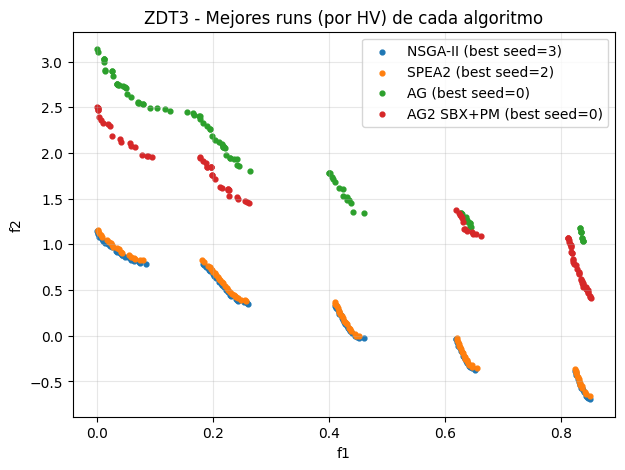

In [90]:
# BEST seed por HV para cada AG
best_seed_ag  = int(df2.loc[df2["HV_AG"].idxmax(), "seed"])
best_seed_ag2 = int(df2.loc[df2["HV_AG_SBXPM"].idxmax(), "seed"])

print("Best seed AG  =", best_seed_ag)
print("Best seed AG2 =", best_seed_ag2)

# mejores runs (cada uno con su seed)
ag_best  = evolve_my_mo(seed=best_seed_ag)
ag2_best = evolve_my_mo_sbxpm(seed=best_seed_ag2)

# Para NSGA/SPEA, hacemos el "best run" también por HV usando esas mismas seeds
# (si en df2 tienes HV_NSGA2 y HV_SPEA2, mejor aún)
best_seed_nsga = int(df2.loc[df2["HV_NSGA2"].idxmax(), "seed"]) if "HV_NSGA2" in df2 else best_seed_ag2
best_seed_spea = int(df2.loc[df2["HV_SPEA2"].idxmax(), "seed"]) if "HV_SPEA2" in df2 else best_seed_ag2

ns_best = run_nsga2(seed=best_seed_nsga)
sp_best = run_spea2(seed=best_seed_spea)

plt.figure(figsize=(7,5))
plt.scatter(ns_best["F_nd"][:,0], ns_best["F_nd"][:,1], s=12, label=f"NSGA-II (best seed={best_seed_nsga})")
plt.scatter(sp_best["F_nd"][:,0], sp_best["F_nd"][:,1], s=12, label=f"SPEA2 (best seed={best_seed_spea})")
plt.scatter(ag_best["F_nd"][:,0],  ag_best["F_nd"][:,1],  s=12, label=f"AG (best seed={best_seed_ag})")
plt.scatter(ag2_best["F_nd"][:,0], ag2_best["F_nd"][:,1], s=12, label=f"AG2 SBX+PM (best seed={best_seed_ag2})")
plt.xlabel("f1"); plt.ylabel("f2")
plt.title("ZDT3 - Mejores runs (por HV) de cada algoritmo")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()